In [9]:
import numpy as np
import ps_utils
import numpy.linalg as la
import matplotlib.pyplot as plt

### 2 Beethoven Dataset 
Beethoven is a synthetic and clean dataset, with exactly 3 images. If nz is the number of pixels inside the non-zero part of the mask, You should create an array J of size/shape (3, nz) and obtain the albedo modulated normal field as $M = S^{-1}J$. With it, extract the albedo within the mask, display it as a 2D image. Then extract the normal field by normalizing M, extract its components n1, n2, n3. Solve for depth and display it at different view points.

In [ ]:
# citation: refine based on the code provided in the beethoven_run.py(author:Francois Lauze)
def woodham_depth_solution(dataset, depth_map_func):
    I, mask, S = ps_utils.read_data_file(dataset)
    nz = np.where(mask > 0)
    m,n = mask.shape
    
    J = np.zeros((S.shape[0],len(nz[0])))
    for i in range(S.shape[0]):
        Ii = I[:,:,i]
        J[i,:] = Ii[nz]
    
    if S.shape[0] == S.shape[1]:
        M = np.dot(la.inv(S),J)
    else:
        M = np.dot(la.pinv(S),J)
           
    albedo = la.norm(M, axis=0)  
    albedo_image = np.zeros((m,n))
    albedo_image[nz] = albedo
    plt.title('Albedo')
    plt.imshow(albedo_image)
    plt.show()  
    
    N = M/albedo
    n1 = np.zeros((m,n))
    n2 = np.zeros((m,n))
    n3 = np.ones((m,n))
    n1[nz] = N[0,:]
    n2[nz] = N[1,:]
    n3[nz] = N[2,:]
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
    ax1.imshow(n1)
    ax2.imshow(n2)
    ax3.imshow(n3)
    fig.subplots_adjust(wspace=0.4)
    plt.show()
    
    z = depth_map_func(n1, n2, n3, mask)
    z = np.nan_to_num(z)
    ps_utils.display_surface(z)

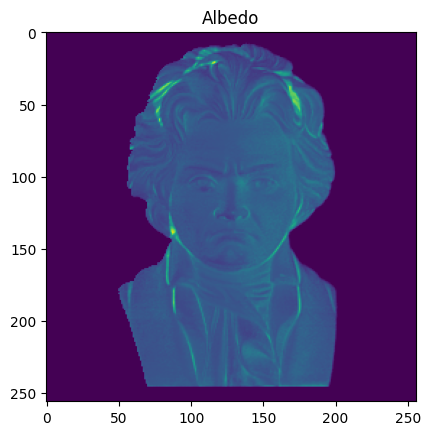

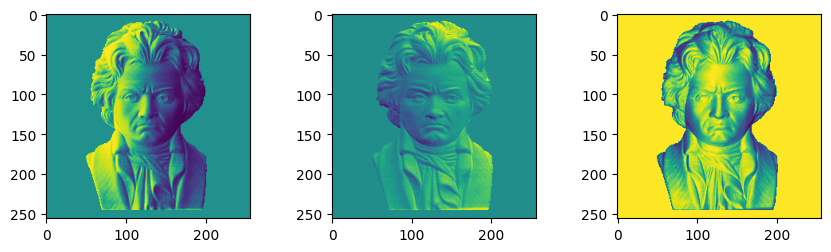

In [ ]:
woodham_depth_solution('Beethoven', ps_utils.simchony_integrate)

### 3 mat_vase Dataset
mat vase is a synthetic and clean dataset, with exactly 3 images. If nz is the number of pixels inside the non-zero part of the mask, You should create an array J of size/shape (3, nz) and obtain the albedo modulated normal field as M = $S^{-1}J$. With it, extract the albedo within the mask, display it as a 2D image. Then extract the normal field by normalizing M, extract its components n1, n2, n3. Solve for depth and display it at different view points.

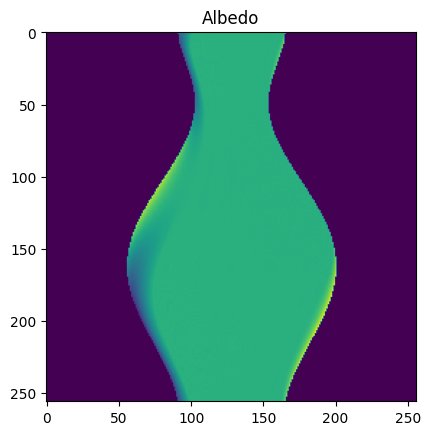

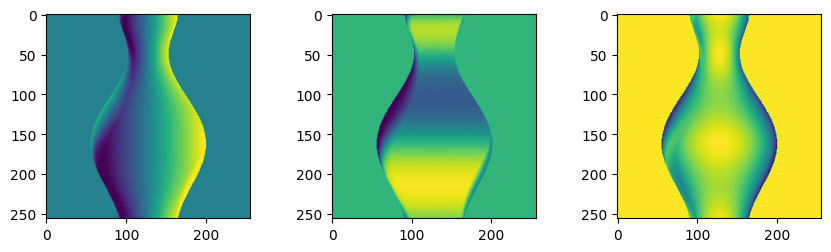

In [23]:
woodham_depth_solution('mat_vase', ps_utils.simchony_integrate)

In [ ]:
woodham_depth_solution('mat_vase', ps_utils.unbiased_integrate)

### 4 shiny_vase Dataset
shiny vase is a synthetic and clean dataset, however not respecting Lambert’s law, which cannot cope with specularities. It also consists of exactly 3 images. If nz is the number of pixels inside the non-zero part of the mask, You should create an array J of size/shape (3, nz) and obtain the albedo modulated normal field as M = $S^{-1}J$. With it, extract the albedo within the mask, display it as a 2D image. Then extract the normal field by normalizing M, extract its components n1, n2, n3. Solve for depth and display it at different view points. Comment on what happens here.

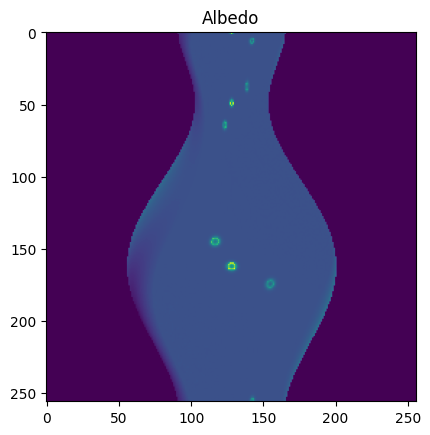

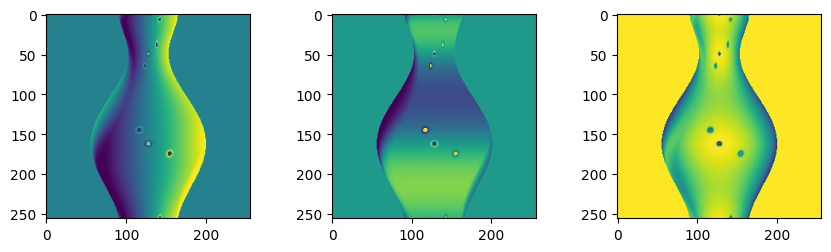

In [21]:
woodham_depth_solution('shiny_vase', ps_utils.unbiased_integrate)

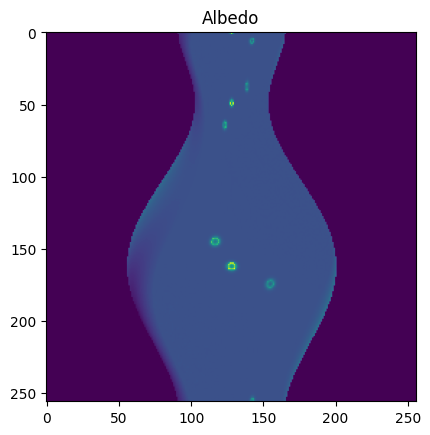

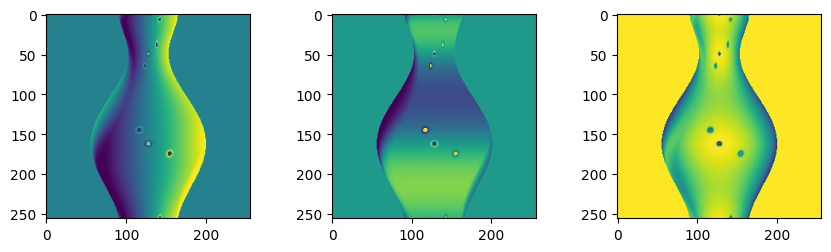

libpng warning: iCCP: known incorrect sRGB profile


In [22]:
woodham_depth_solution('shiny_vase', ps_utils.simchony_integrate)

Do you think that RANSAC could provide a better estimation of normals? Explain. You should try and replace Woodham’s first step (via inverse/pseudoinverse) with RANSAC estimation. The threshold parameter in ransac 3dvector() should no more than be 2.0. After the estimation for each pixel, extract the normals and the albedo. Display and comment on the results. Do they differ from Woodham’s estimation? Try then to make the estimated normal field smoother using the smooth normal field() function. You may experiment with the iters parameter.

In [ ]:
# citation: refine based on the code provided in the beethoven_run.py(author:Francois Lauze)
def Ransac_depth_solution(dataset, depth_map_func, threshold=2,smooth = False,iters=100):
    I, mask, S = ps_utils.read_data_file(dataset)
    nz = np.where(mask > 0)
    m,n = mask.shape
    
    J = np.zeros((S.shape[0],len(nz[0])))
    for i in range(S.shape[0]):
        Ii = I[:,:,i]
        J[i,:] = Ii[nz]
    
    normal = np.zeros((3, len(nz[0])))
    albedo = np.zeros(len(nz[0]))
     
    for i in range(len(nz[0])):
        data = (J[:,i],S)
        result = ps_utils.ransac_3dvector(data, threshold=threshold, verbose=0)
        if result:
            best_m,_,_ = result
            albedo[i] = la.norm(best_m)
            normal[:,i] = best_m/albedo[i]
    
    #data = (J, S)    
    #normal = ps_utils.ransac_3dvector(data, threshold=2)
    #albedo = la.norm(normal, axis=0)   
    
    n1, n2, n3 = np.zeros((m,n)),np.zeros((m,n)),np.ones((m,n))
    n1[nz], n2[nz], n3[nz] = normal
    if smooth:
        n1, n2, n3 = ps_utils.smooth_normal_field(n1,n2,n3,mask,iters=iters)   
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
    ax1.imshow(n1)
    ax2.imshow(n2)
    ax3.imshow(n3)
    if smooth:
        fig.suptitle(f'Iters = {iters}', y=0.85)
    fig.subplots_adjust(wspace=0.4)
    plt.show()
    
    albedo_image = np.zeros((m,n))
    albedo_image[nz] = albedo
    plt.figure(figsize=(3, 3))
    plt.imshow(albedo_image)
    plt.show()

    z = depth_map_func(n1, n2, n3, mask)
    z = np.nan_to_num(z)
    
    ps_utils.display_surface(z)
    
            

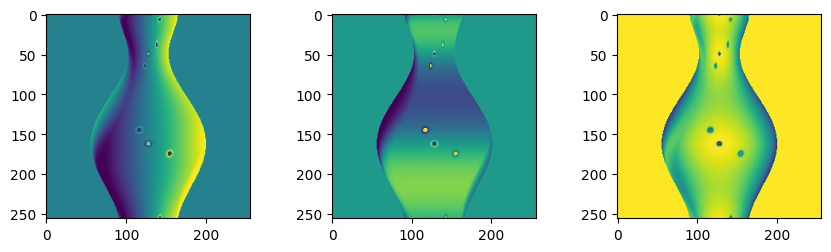

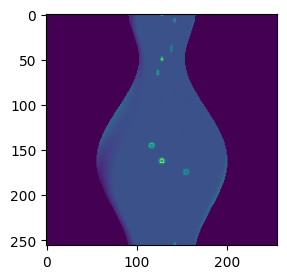

In [34]:
Ransac_depth_solution('shiny_vase', ps_utils.simchony_integrate, threshold=2)

In [ ]:
#make the estimated normal field smoother using the smooth normal field() function
Ransac_depth_solution('shiny_vase', ps_utils.simchony_integrate, threshold=2, smooth = True, iters=100)
Ransac_depth_solution('shiny_vase', ps_utils.simchony_integrate, threshold=2, smooth = True, iters=50)
Ransac_depth_solution('shiny_vase', ps_utils.simchony_integrate, threshold=2, smooth = True, iters=150)

### 5 shiny_vase2 Dataset
shiny vase2 is a synthetic and clean dataset, however not respecting Lambert’s law, which cannot cope with specularities. It consists of exactly 22 images. If nz is the number of pixels inside the non-zero part of the mask, You should create an array J of size/shape (22,nz) and obtain the albedo modulated normal field as M = S†J. With it, extract the albedo within the mask, display it as a 2D image. Then extract the normal field by normalizing M, extract its components n1, n2, n3. Solve for depth and display it at different view points. Comment on what happens here.

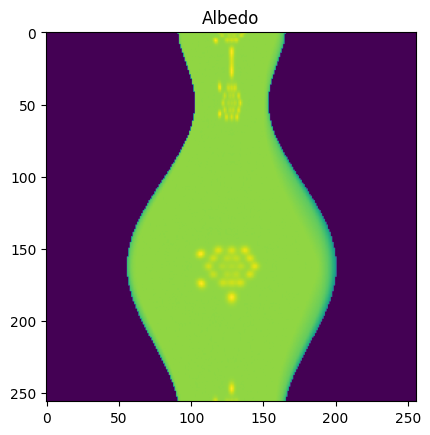

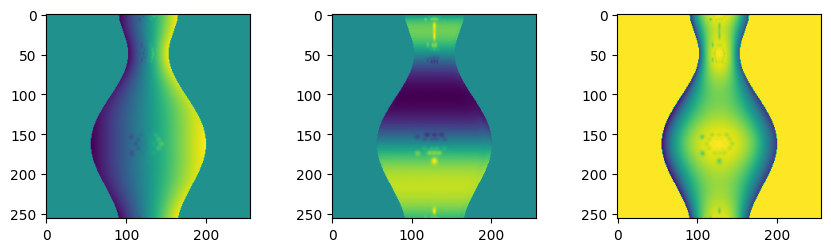

In [42]:
woodham_depth_solution('shiny_vase2', ps_utils.simchony_integrate)

Do you think that RANSAC could provide a better estimation of normals? Explain. You should try and replace Woodham’s first step (via inverse/pseudoinverse) with RANSAC estimation. The threshold parameter in ransac 3dvector() should no more than be 2.0. After the estimation for each pixel, extract the normals and the albedo. Display and comment on the results. Do they differ from Woodham’s estimation? Try then to make the estimated normal field smoother using the smooth normal field() function. You may experiment with the iters parameter.

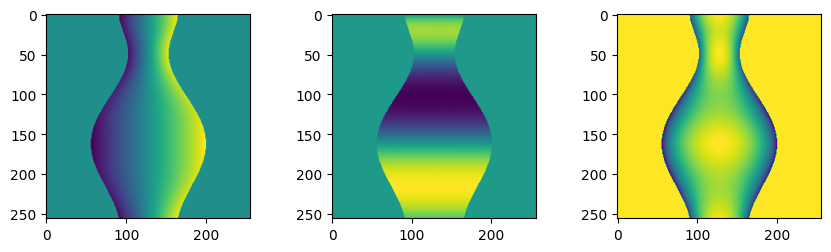

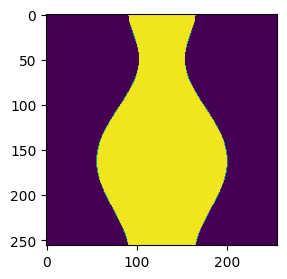

In [43]:
Ransac_depth_solution('shiny_vase2', ps_utils.simchony_integrate, threshold=2)

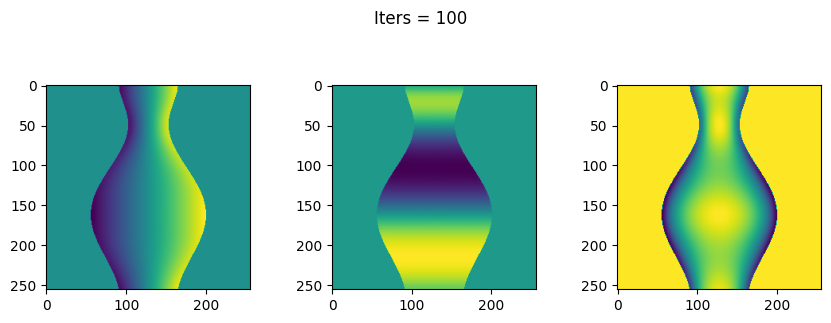

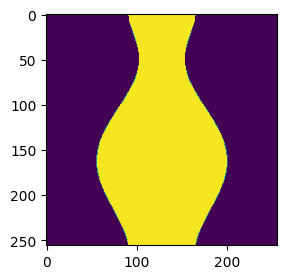

In [45]:
Ransac_depth_solution('shiny_vase2', ps_utils.simchony_integrate, threshold=2, smooth = True, iters=100)

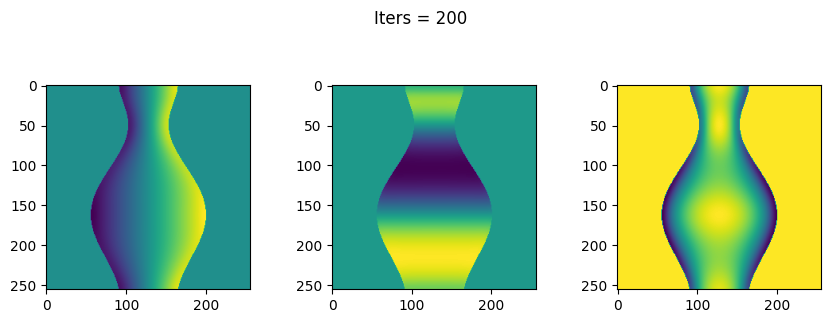

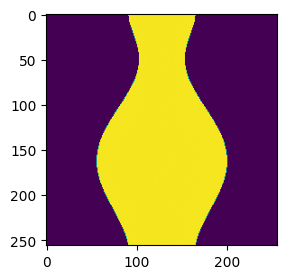

In [47]:
Ransac_depth_solution('shiny_vase2', ps_utils.simchony_integrate, threshold=2, smooth = True, iters=200)

### 6 Buddha Dataset
Buddha is real dataset, with exactly 10 images. If nz is the number of pixels inside the non-zero part of the mask, You should create an array J of size/shape (10,nz) and obtain the albedo modulated normal field as M = S†J (the pseudo-inverse). With it, extract the albedo within the mask, display it as a 2D image. Then extract the normal field by normalizing M, extract its components n1, n2, n3. Solve for depth and display it at different view points.

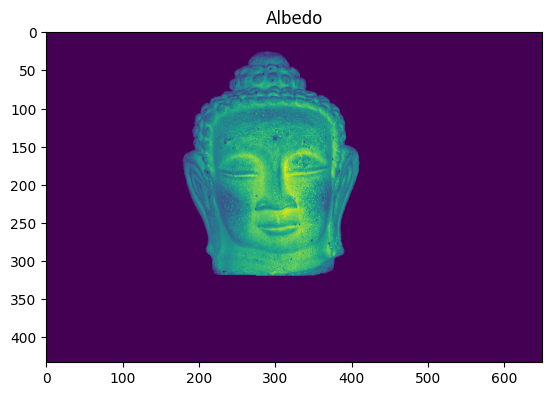

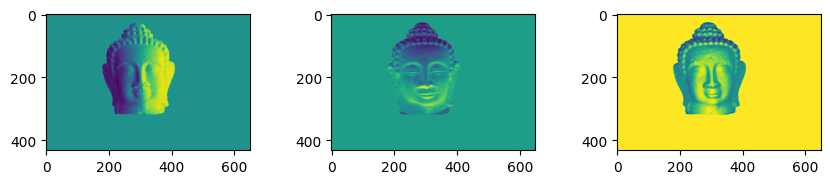

In [48]:
woodham_depth_solution('Buddha', ps_utils.simchony_integrate)

You should try and replace Woodham’s first step (via inverse/pseudoinverse) with an estimation using RANSAC. The threshold parameter in ransac 3dvector() should be at least 25.0 Experiment with it. After the estimation for each pixel, extract the normals and the albedo. Display and comment on the results. Try then to make the estimated normal field smoother using the smooth normal field() function. You may experiment with the iters parameter.

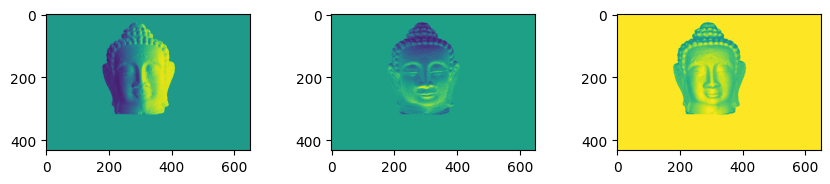

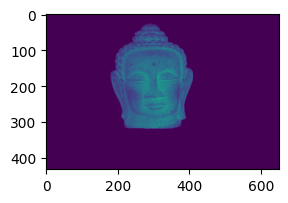

In [49]:
Ransac_depth_solution('Buddha', ps_utils.unbiased_integrate, threshold=200)

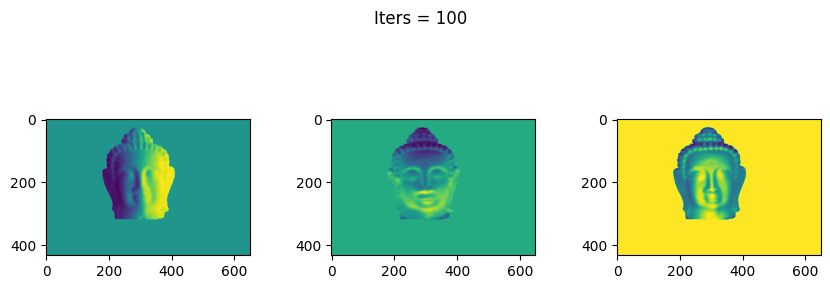

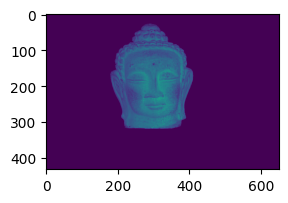

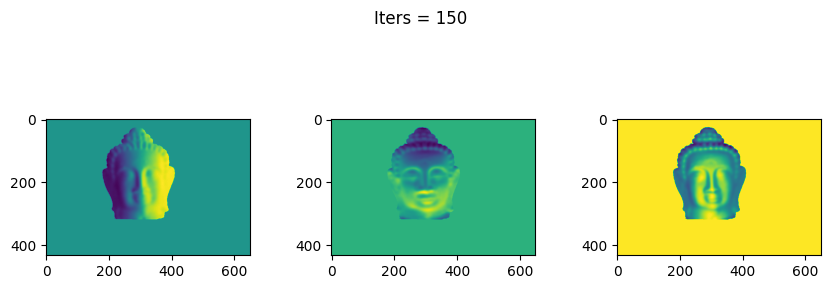

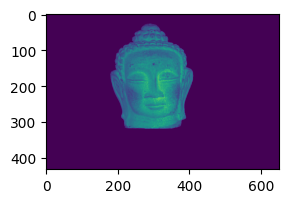

In [51]:
Ransac_depth_solution('Buddha', ps_utils.simchony_integrate, threshold=200, smooth = True, iters=100)
Ransac_depth_solution('Buddha', ps_utils.simchony_integrate, threshold=200, smooth = True, iters=150)

### 7 face Dataset
Buddha is real dataset, with exactly 27 images. If nz is the number of pixels inside the non-zero part of the mask, You should create an array J of size/shape (27,nz) and obtain the albedo modulated normal field via RANSAC with a threshold of 10.0 Try then to make the estimated normal field smoother using the smooth normal field() function. You may experiment with the iters parameter. Report your results.

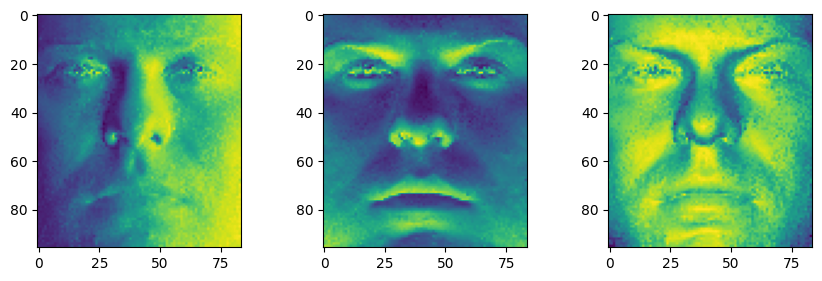

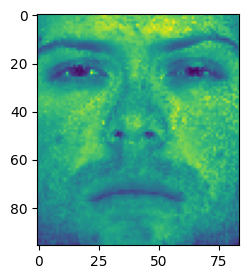

In [52]:
Ransac_depth_solution('face', ps_utils.simchony_integrate, threshold=10.0)

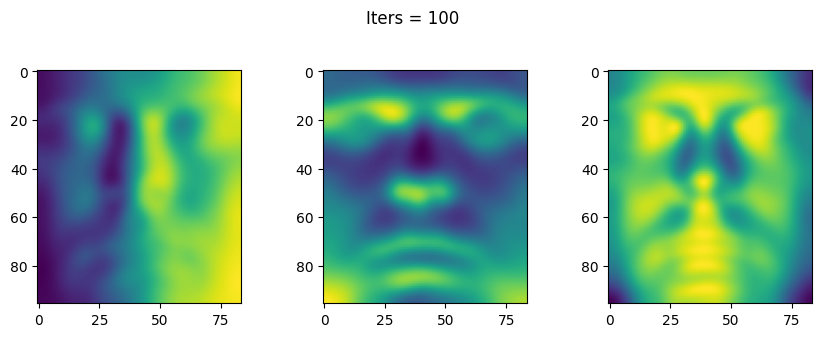

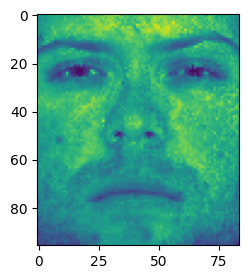

In [53]:
Ransac_depth_solution('face', ps_utils.simchony_integrate, threshold=10.0, smooth = True, iters=100)

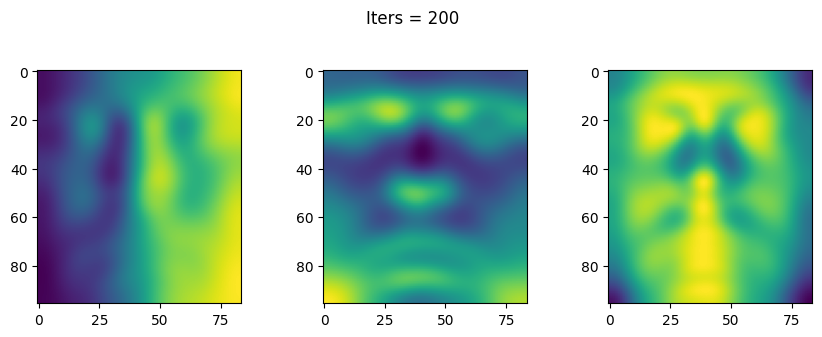

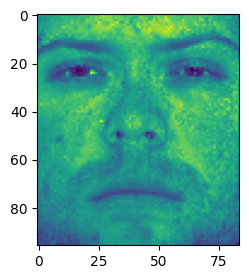

In [54]:
Ransac_depth_solution('face', ps_utils.simchony_integrate, threshold=10.0, smooth = True, iters=200)